In [108]:
# Imports
import os
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt

In [109]:
torch.manual_seed(143)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [110]:
# Get Dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
testset = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:01, 5449903.57it/s]                             


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 259161.33it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 3086172.94it/s]                            
8192it [00:00, 106689.04it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


torch.Size([1, 28, 28])


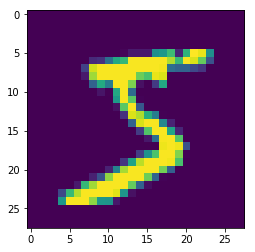

5


In [111]:
# Inspect one image from the dataset
img, label = trainset.__getitem__(0)
print(img.size())

def imshow(img):
    # Expects an img in tensor -1 to 1 range
    #img = (img + 1)/2.0
    npimg = img.squeeze().numpy()
    plt.imshow(npimg)
    plt.show()

imshow(img)
print(label)

In [112]:
# Create a data loader for dataset
batch_size = 128
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                           shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                           shuffle=False, num_workers=2)

In [113]:
# Create the encoder
latent_dim = 2
hidden_dim = 400

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x.view(-1, 784)))
        mu = self.fc21(x)
        logvar = self.fc22(x)
        return mu, logvar

# Creates the decoder class
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 784)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.sigmoid(x)

# Creates the VAE class
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def reparam(self, mu, logvar):
        sigma = torch.exp(0.5*logvar)
        eps = torch.randn_like(sigma)
        return mu + eps*sigma
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparam(mu, logvar)
        x = self.decoder(z)
        return x, mu, logvar

In [114]:
# Define the loss function involved
def loss_func(x, recon_x, mu, logvar):
    #recon_loss = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    recon_loss = F.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
    KL_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + KL_loss

In [115]:
# Define the training process
def train(epoch, model, optimizer, train_loader):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(data)
        loss = loss_func(data, recon, mu, logvar)
        loss.backward()
        train_loss += loss
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train_epoch: {}\t[{}/{}]\tLoss: {:.6f}'.format(
                epoch, batch_idx*len(data), len(train_loader.dataset), 
                loss.item()/len(data)))
    print('Epoch: {} Avg train loss = {:.6f}'.format(
        epoch, train_loss/len(train_loader.dataset)))

In [ ]:
# Define the test process
def test(epoch, model, test_loader):
    model.eval()
    test_loss = 0
    for data, _ in test_loader:
        data = data.to(device)
        recon, mu, logvar = model(data)
        loss = loss_func(data, recon, mu, logvar)
        test_loss += loss
    test_loss /= len(test_loader.dataset)
    print('Epoch: {} Avg test loss: {:.6f}'.format(epoch, test_loss))

In [ ]:
model = VAE().to(device)
model = nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
optimizer = optim.Adam(model.parameters(), lr=1e-3)

results_dir = 'results'
if not os.path.exists(results_dir):
    os.mkdir(results_dir)
else:
    print('Directory', results_dir, 'already exists')

for epoch in range(1, 20):
    train(epoch, model, optimizer, train_loader)
    test(epoch, model, test_loader)
    with torch.no_grad():
        sample = torch.randn(64, latent_dim).to(device)
        sample = model.module.decoder(sample).cpu()
        sample_filename = os.path.join(results_dir, 'sample_' + str(epoch) + '.png')
        save_image(sample.view(64, 1, 28, 28), sample_filename)

Train_epoch: 1	[0/60000]	Loss: 184.444321
Train_epoch: 1	[25600/60000]	Loss: 48.524063
Train_epoch: 1	[51200/60000]	Loss: 47.369255
Epoch: 1 Avg train loss = 50.131027
Epoch: 1 Avg test loss: 44.327679
Train_epoch: 2	[0/60000]	Loss: 41.602646
Train_epoch: 2	[25600/60000]	Loss: 44.463203
Train_epoch: 2	[51200/60000]	Loss: 44.423939
Epoch: 2 Avg train loss = 43.211666
Epoch: 2 Avg test loss: 42.671375
Train_epoch: 3	[0/60000]	Loss: 40.014095
Train_epoch: 3	[25600/60000]	Loss: 43.573746
Train_epoch: 3	[51200/60000]	Loss: 43.580910
Epoch: 3 Avg train loss = 42.196541
Epoch: 3 Avg test loss: 41.923019
Train_epoch: 4	[0/60000]	Loss: 38.840454
Train_epoch: 4	[25600/60000]	Loss: 42.447224
Train_epoch: 4	[51200/60000]	Loss: 42.963448
Epoch: 4 Avg train loss = 41.638470
Epoch: 4 Avg test loss: 41.465099
Train_epoch: 5	[0/60000]	Loss: 38.280609
Train_epoch: 5	[25600/60000]	Loss: 41.961849
Train_epoch: 5	[51200/60000]	Loss: 42.397339
Epoch: 5 Avg train loss = 41.205856
Epoch: 5 Avg test loss: 41.2

In [ ]:
# Create an array of images for hidden dim = 2
with torch.no_grad():
    n = 32
    sample = torch.linspace(-1.0, 1.0, steps=n)
    x, y = torch.meshgrid(sample, sample)
    x = x.unsqueeze(2)
    y = y.unsqueeze(2)
    sample = torch.cat((x, y), 2)
    sample = sample.view(-1, 2).to(device)
    sample = model.module.decoder(sample).cpu()
    sample_filename = os.path.join(results_dir, 'final' + '.png')
    save_image(sample.view(n*n, 1, 28, 28), sample_filename, nrow=n)